# Figure 6 – Open field HMM analysis

In [2]:
%load_ext watermark
%watermark -a "Etienne Ackermann," -n -t -v -p nelpy,numpy,scipy,pandas,matplotlib

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
Etienne Ackermann, Wed May 16 2018 12:09:24 

CPython 3.5.4
IPython 6.2.1

nelpy 0.1.2
numpy 1.11.3
scipy 0.19.0
pandas 0.19.2
matplotlib 2.1.2


In [3]:
import copy
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import os
import seaborn as sns
import time
import warnings

import scipy.ndimage.filters
import tabulate

from IPython.display import HTML, display, clear_output

import nelpy as nel
import nelpy.plotting as npl

from sklearn.model_selection import train_test_split
from mpl_toolkits.axes_grid1 import make_axes_locatable

from nelpy import hmmutils
from nelpy.decoding import k_fold_cross_validation
from nelpy.decoding import decode2D

# Set default figure aesthetics
npl.setup(font_scale=1.4)

%matplotlib inline

warnings.filterwarnings("ignore")

/home/etienne/anaconda3/lib/python3.5/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: The mpl_toolkits.axes_grid module was deprecated in version 2.1. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist provies the same functionality instead.


## Load data

In [4]:
datadirs = ['data/']

fileroot = next( (dir for dir in datadirs if os.path.isdir(dir)), None)

if fileroot is None:
    raise FileNotFoundError('datadir not found')

load_from_nel = True

if load_from_nel:
    jar = nel.load_pkl(fileroot + 'openfield.nel')
    ratdays = jar.ratdays
    data = jar.data
    del jar


# Look at percentile curve

In [6]:
# first, compute percentiles from scores:
import scipy.stats as stats

for rat, day in ratdays:
    n_scores = len(data[rat][day]['scores_tmat_all'])
    scores_hmm_percentile = np.array([stats.percentileofscore(data[rat][day]['scores_tmat_all'][idx], data[rat][day]['scores_logprob_all'][idx], kind='mean') for idx in range(n_scores)])
    data[rat][day]['scores_hmm_percentile'] = scores_hmm_percentile
    
pooled_percentiles_hmm = [] 
for rat, day in ratdays:
    pooled_percentiles_hmm.extend(data[rat][day]['scores_hmm_percentile'].tolist())
    
pooled_percentiles_hmm = np.array(sorted(pooled_percentiles_hmm))

sig events: 37.3 %
threshold: 84.48


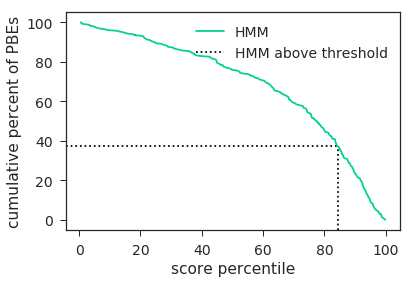

In [7]:
threshold = 84.48

n_scores = len(pooled_percentiles_hmm)
x = 100 - np.linspace(0,100, n_scores)

plt.plot(pooled_percentiles_hmm, x, label='HMM')
hx = 100 - [next(ii for (ii, item) in enumerate((pooled_percentiles_hmm<threshold).tolist()) if item is False)][0]/n_scores*100

ax = plt.gca()
xlims = ax.get_xlim()
ylims = ax.get_ylim()

ax.hlines(hx, xmin=xlims[0], xmax=threshold, linestyle=':', label='HMM above threshold')
ax.set_ylim(ylims)
ax.vlines(threshold, ymin=ylims[0], ymax=hx, linestyle=':')
ax.set_xlim(xlims)
ax.set_ylabel('cumulative percent of PBEs')
ax.set_xlabel('score percentile')

cum_perc_sig = 30 # desired number of significant events
threshold_hmm = float(pooled_percentiles_hmm[np.argwhere(x < cum_perc_sig)[0]])

print('sig events: {:1.1f} %'.format(hx))
print('threshold: {}'.format(threshold))
plt.legend(loc=1)

# npl.savefig('thresholds_2d', formats=['svg','pdf','png'], overwrite=True)

# Decoding error, pooled

This is now computed and aggregated in a separate notebook

# Comparison matrix when matching to BP's overall #sig events

In [7]:
# here we find the POOLED threshold that would lead to us having
# roughly the same number of significant events as BP

In [8]:
# find number of BP significant events, pooled over all 8 sessions:
n_BP_sig = 0
n_PBEs = 0
for rat, day in ratdays:
    n_BP_sig += len(data[rat][day]['BradSignificantRippleIDs'])
    n_PBEs += data[rat][day]['PBEs'].n_epochs
    
print('Brad Pfeiffer reported {}/{} ({:1.1f} %) significant events...'.format(n_BP_sig, n_PBEs, n_BP_sig/n_PBEs*100))

Brad Pfeiffer reported 815/2980 (27.3 %) significant events...


In [9]:
# obtain thresholds from pooled data
cum_perc_sig = n_BP_sig/n_PBEs*100
threshold_hmm = float(pooled_percentiles_hmm[np.argwhere(x < cum_perc_sig)[0]])
print('using HMM threshold of {:1.2f} %'.format(threshold_hmm))

n_events_total = 0
n_HS_BS = 0
n_HS_BNS = 0
n_HNS_BS = 0
n_HNS_BNS = 0
    
for rat, day in ratdays:
    n_events = len(data[rat][day]['scores_hmm_percentile'])
    n_events_total += n_events
    idx_all = set(range(n_events))
    BS = set(data[rat][day]['BradSignificantRippleIDs'])
    BNS = idx_all - BS
#     raise NotImplementedError
    HS = set(np.where(data[rat][day]['scores_hmm_percentile']>=threshold_hmm)[0])
    HNS = set(np.where(data[rat][day]['scores_hmm_percentile']<threshold_hmm)[0])
    BS_HS = np.array(list(BS.intersection(HS))).astype(int)
    BS_HNS = np.array(list(BS.intersection(HNS))).astype(int)
    BNS_HS = np.array(list(BNS.intersection(HS))).astype(int)
    BNS_HNS = np.array(list(BNS.intersection(HNS))).astype(int)

    n_HS_BS += len(BS_HS)
    n_HS_BNS += len(BNS_HS)
    n_HNS_BS += len(BS_HNS)
    n_HNS_BNS += len(BNS_HNS)

conf_mat = np.array([[n_HS_BNS, n_HS_BS],[n_HNS_BNS, n_HNS_BS]])

table = [["HMM +", n_HS_BS, n_HS_BNS, n_HS_BS+n_HS_BNS],
         ["HMM -", n_HNS_BS, n_HNS_BNS, n_HNS_BS + n_HNS_BNS],
        ["", n_HS_BS + n_HNS_BS, n_HS_BNS + n_HNS_BNS, ""]]
display(HTML(tabulate.tabulate(table, headers=["N={}".format(n_events_total),"Brad +", "Brad -", ""], tablefmt='html')))

oddsratio, p_value = stats.fisher_exact(np.array([[n_HS_BNS, n_HS_BS],[n_HNS_BNS, n_HNS_BS]]), alternative='two-sided')
print("Fisher's exact test, two-tailed p value:", p_value)

print('{:1.1f}% event agreement'.format((n_HS_BS + n_HNS_BNS) / n_events_total*100))


using HMM threshold of 97.28 %


N=2980,Brad +,Brad -,
HMM +,259,556,815
HMM -,556,1609,2165
,815,2165,


Fisher's exact test, two-tailed p value: 0.00105440424046
62.7% event agreement


## Set experimental parameters

In [10]:
num_states = 50 # number of states for PBE HMM
ds = 0.02 # 20 ms bin size for PBEs
ds_tc = 0.25 # 250 ms time bin for estimating tuning curves for Bayesian decoding
min_tc_duration = 0 # mininmum observation time in seconds, before a bin contributes to the tuning curve
sigma_tc = 4 # 4 cm smoothing on tuning curves

ratday = ('Rat1', 'Day1')

## Compute additional objects required for figure

### 1. Compute PBEs

In [11]:
rat, day = ratday

# get spike train
# remove interneurons:
st = data[rat][day]['st']._unit_subset(data[rat][day]['ExcitatoryNeuronIDs'])
data[rat][day]['st'] = st

# limit spike train to PBE event boundaries; NOTE: we may want to overwrite this definition with our own
mua_spks = st[data[rat][day]['BradRippleStartEndTimes']]
PBEs = mua_spks.bin(ds=ds)
data[rat][day]['PBEs'] = PBEs
print(PBEs)

<BinnedSpikeTrainArray at 0x7ff0bb9a30f0: 203 units (322 segments) in 2,900 bins of width 20.0 milliseconds> for a total of 58 seconds


### 2. Train HMM on PBEs

In [12]:
# here we train on 80%, test on 20%; this will be similar to when we do 5-fold cross validation later on
trainidx, testidx = train_test_split(np.arange(PBEs.n_epochs), test_size=0.2, random_state=1)

trainidx.sort()
testidx.sort()

PBEs_train = PBEs[trainidx]
PBEs_test = PBEs[testidx]

print('{} train PBEs and {} test PBEs'.format(len(trainidx),len(testidx)))

# train HMM on all training PBEs
hmm = nel.hmmutils.PoissonHMM(n_components=num_states, random_state=0, verbose=False)
hmm.fit(PBEs_train)

# reorder states according to transmat ordering
transmat_order = hmm.get_state_order('transmat')
hmm.reorder_states(transmat_order)

257 train PBEs and 65 test PBEs


### 3. Compute tuning curves for Bayesian decoding

In [13]:
# Etienne to previous Etienne: why don't you compute this only during RUN? Was this just a prelim check?
# bst = st.bin(ds=ds_tc)
# pos = data[rat][day]['pos']
# tc2d = nel.TuningCurve2D(bst=bst, extern=pos, min_duration=min_tc_duration, ext_nx=100, ext_ny=100, ext_xmin=90, ext_xmax=290, ext_ymin=0, ext_ymax=200)
# tc2d = tc2d.smooth(sigma=sigma_tc)

# UPDATE: I do compute tuning curves during RUN in the all-sequences notebook, where I do Bayesian decoding

st = data[rat][day]['st']
pos = data[rat][day]['pos']
PBEs = data[rat][day]['PBEs']
speed = nel.utils.dxdt_AnalogSignalArray(pos, smooth=True)
run_epochs = nel.utils.get_run_epochs(speed, v1=10, v2=8)

run_st = st[run_epochs]

ds_TC = 1/pos.fs # 250 ms; time bin size for learning tuning curves for Bayesian decoding
run_bst = run_st.bin(ds=ds_TC)

tvals, vals = pos.asarray()
xvals, yvals = vals

ext_xmin = xvals.min()
ext_xmax = ext_xmin + 204
ext_ymin = 0
ext_ymax = 200

tc2d = nel.TuningCurve2D(bst=run_bst, extern=pos, min_duration=0, ext_nx=100, ext_ny=100, ext_xmin=ext_xmin, ext_xmax=ext_xmax, ext_ymin=ext_ymin, ext_ymax=ext_ymax)

# Brad smoothed position estimates with SD of 4 cm
tc2d = tc2d.smooth(sigma=sigma_tc)

### 3.b Look at spatial information of units

In [22]:
# si = tc2d.spatial_information()
# sp = tc2d.spatial_sparsity()

# tvals, vals = pos.asarray()
# xvals, yvals = vals

# xx_mid = tc2d.xbin_centers
# yy_mid = tc2d.ybin_centers

# with npl.palettes.color_palette(npl.colors.rainbow):
#     with npl.FigureManager(show=False, figsize=(16, 30), nrows=10, ncols=5) as (fig, axes):
#         npl.utils.skip_if_no_output(fig)
#         for ii, ax in enumerate(axes.ravel()):
#             placefield = tc2d.ratemap[ii,:,:]
#             npl.imagesc(x=xx_mid, y=yy_mid, data=placefield, cmap=plt.cm.hot, ax=ax)
#             ax.set_title('unit {}: sp {:.2f}'.format(ii+1, sp[ii]))
#             npl.utils.clear_left_right(ax)
#             npl.utils.clear_top_bottom(ax)

### 4. Compute Bayesian decoded examples of BP and HMM significant events

In [36]:
bst_20 = mua_spks.bin(ds=0.02)
bst_05 = mua_spks.bin(ds=0.005)
bst_10 = mua_spks.bin(ds=0.01)

# some good examples include events 8, 12, 15, 19, 33, 50, 79, 117, 168, 183, 186, 187, 252, 271, 272, 284, ...

ex1 = {}
ex2 = {}
ex3 = {}
ex4 = {}

ex1['idx'] = 15
ex2['idx'] = 33
ex3['idx'] = 210
ex4['idx'] = 248 

examples = [ex1, ex2, ex3, ex4]

for ex in examples:
    bst = bst_20[ex['idx']]
    posterior, lengths, mode_pth, mean_pth = decode2D(bst, tc2d, w=1)
    ex['path20_1'] = mean_pth
    bst = bst_05[ex['idx']]
    posterior, lengths, mode_pth, mean_pth = decode2D(bst, tc2d, w=4)
    ex['path20_5'] = mean_pth
    tvals, posvals = pos.asarray(at=bst.bin_centers)
    ex['actual_pos'] = posvals

### 5. Compute virtual tuning curves

In [37]:
def sub2ind(array_shape, rows, cols):
    return rows*array_shape[1] + cols

In [112]:
ds_run = 0.1 # 200 ms
ds_50ms = 0.05
# st_run = st[run_epochs1 + run_epochs2]
st_no_ripple = st[~data[rat][day]['BradRippleStartEndTimes']]

pos = data[rat][day]['pos']

# smooth and re-bin:
sigma = 0.3 # 300 ms spike smoothing
bst_no_ripple = st_no_ripple.bin(ds=ds_50ms).smooth(sigma=sigma, inplace=True).rebin(w=ds_run/ds_50ms)

bst = bst_no_ripple
xpos, ypos = pos.asarray(at=bst.centers).yvals

ext_nx=200
ext_ny=200
x0=90; xl=290;
y0=0; yl=200;

xx_left = np.linspace(x0,xl,ext_nx+1)
xx_mid = np.linspace(x0,xl,ext_nx+1)[:-1]; xx_mid += (xx_mid[1]-xx_mid[0])/2
yy_left = np.linspace(y0,yl,ext_ny+1)
yy_mid = np.linspace(y0,yl,ext_ny+1)[:-1]; yy_mid += (yy_mid[1]-yy_mid[0])/2

ext_y = np.digitize(ypos, yy_left) - 1 # spatial bin numbers
ext_x = np.digitize(xpos, xx_left) - 1

t = np.zeros(len(xpos), dtype=np.float)

for ii, (x, y) in enumerate(zip(ext_x, ext_y)):
    t[ii] = sub2ind((ext_nx, ext_ny), x, y)
    
t[t==0] = np.nan
t[t>=ext_nx*ext_ny] = np.nan
    
extern = hmm.fit_ext(X=bst_no_ripple, ext=t, n_extern=ext_nx*ext_ny)
# transform into ratemap shape
tmp = np.reshape(extern, (num_states, ext_nx, ext_ny))
vtc_ratemap = np.transpose(tmp, (0,2,1)) # for images, we have (y,x) <==> (r,c) coordinates

vtc2d = nel.TuningCurve2D(ratemap=vtc_ratemap, min_duration=min_tc_duration, ext_xmin=x0, ext_xmax=xl, ext_ymin=y0, ext_ymax=yl)
vtc2d = vtc2d.smooth(sigma=sigma_tc)

vtc_ratemap = vtc2d.ratemap # (n_units, y, x)

# now replace hmm._extern_ with smoothed version:
# tmp2 = np.transpose(vtc_ratemap, (0,2,1))
# extern_smooth = np.reshape(tmp2, (num_states, ext_nx*ext_ny))
# hmm._extern_ = extern_smooth

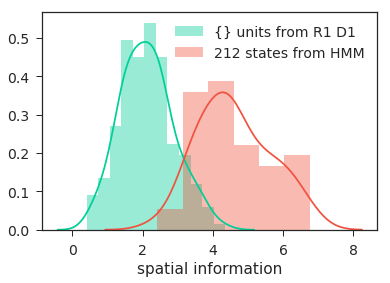

In [63]:
sns.distplot(tc2d.spatial_information(), label='{} units from R1 D1')
sns.distplot(vtc2d.spatial_information(), label='212 states from HMM')
plt.legend()
plt.xlabel('spatial information')

### 6. Compute HMM decoded examples of BP and HMM significant events

In [124]:
hmm_ex1 = {}
hmm_ex2 = {}
hmm_ex3 = {}
hmm_ex4 = {}

hmm_ex1['idx'] = 15
hmm_ex2['idx'] = 33
hmm_ex3['idx'] = 210
hmm_ex4['idx'] = 248

vtc_examples = [hmm_ex1, hmm_ex2, hmm_ex3, hmm_ex4]

for ex in vtc_examples:
    bst = bst_20[ex['idx']]
    posterior, bdries, mode_pth, mean_pth = hmm.decode_ext(bst, ext_shape=(ext_nx, ext_ny))
    mean_pth[0,:] = vtc2d.xbins[0] + mean_pth[0,:]*(vtc2d.xbins[-1] - vtc2d.xbins[0])
    mean_pth[1,:] = vtc2d.ybins[0] + mean_pth[1,:]*(vtc2d.ybins[-1] - vtc2d.ybins[0])
    ex['path20_1'] = mean_pth
    tvals, posvals = pos.asarray(at=bst.bin_centers)
    ex['actual_pos'] = posvals

pdf saved successfully...
png saved successfully...


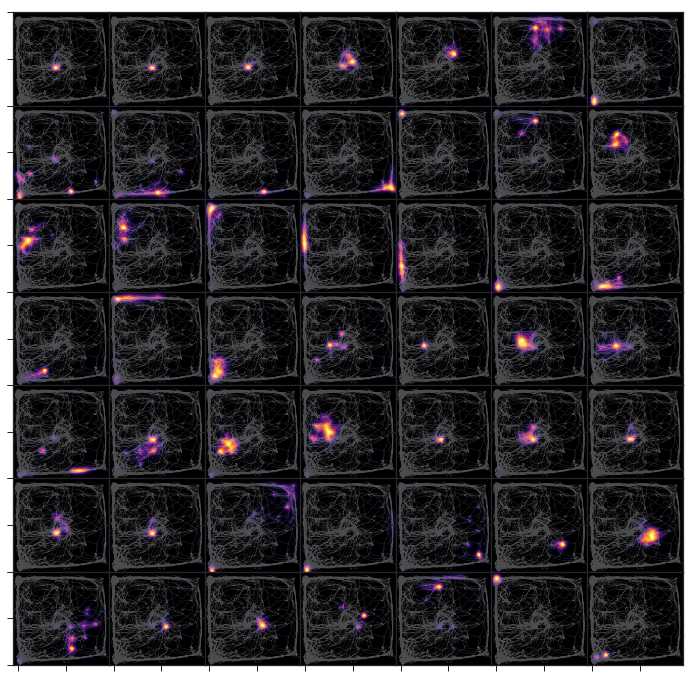

In [140]:
plt.figure(figsize = (12, 12))
gs1 = mpl.gridspec.GridSpec(7, 7)
gs1.update(wspace=0, hspace=0) # set the spacing between axes. 

tvals, vals = pos.simplify(n_points=15000).asarray()
xvals, yvals = vals

for ii in range(49):
    # i = i + 1 # grid spec indexes from 0
    ax = plt.subplot(gs1[ii])
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_aspect('equal')
    placefield = vtc_ratemap[ii]
    npl.imagesc(x=xx_mid, y=yy_mid, data=placefield, cmap=plt.cm.inferno, ax=ax)
    ax.plot(xvals, yvals, lw=0.25, color='w', alpha=0.3)
#     npl.utils.clear_left_right(ax)
#     npl.utils.clear_top_bottom(ax)
    
# npl.savefig('vtcclean49new', overwrite=True)
    

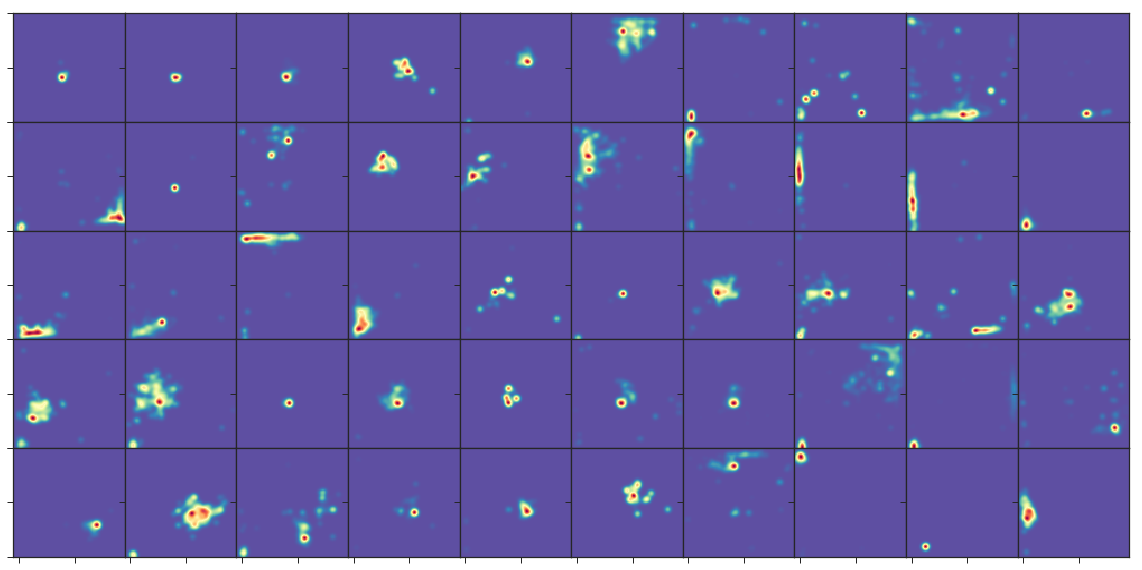

In [46]:
# plt.figure(figsize = (20, 10))
# gs1 = mpl.gridspec.GridSpec(5, 10)
# gs1.update(wspace=0, hspace=0) # set the spacing between axes. 

# tvals, vals = pos.simplify(n_points=2500).asarray()
# xvals, yvals = vals

# for ii in range(50):
#    # i = i + 1 # grid spec indexes from 0
#     ax = plt.subplot(gs1[ii])
#     ax.set_xticklabels([])
#     ax.set_yticklabels([])
#     ax.set_aspect('equal')
#     placefield = vtc_ratemap[ii]
#     npl.imagesc(x=xx_mid, y=yy_mid, data=placefield, cmap=plt.cm.Spectral_r, ax=ax)
# #     ax.plot(xvals, yvals, lw=0.25, color='w', alpha=0.5)
# #     npl.utils.clear_left_right(ax)
# #     npl.utils.clear_top_bottom(ax)
    
# # npl.savefig('vtcclean')
    

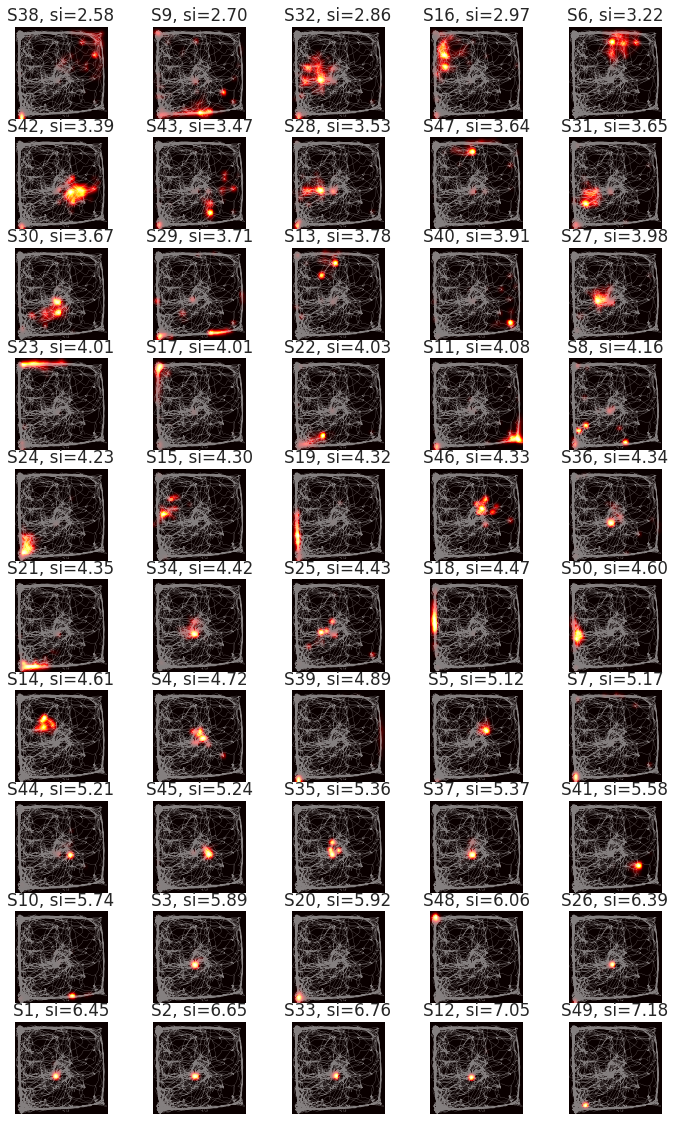

In [47]:
tvals, vals = pos.asarray()
xvals, yvals = vals

si = vtc2d.spatial_information()
sp = vtc2d.spatial_sparsity()

uusorted = np.argsort(si) # sort unit IDS in ascending order of spatial information

with npl.palettes.color_palette(npl.colors.rainbow):
    with npl.FigureManager(show=True, figsize=(12, 20), nrows=10, ncols=5) as (fig, axes):
        npl.utils.skip_if_no_output(fig)
        for ii, ax in enumerate(axes.ravel()):
            ni = uusorted[ii]
            placefield = vtc_ratemap[ni]
            npl.imagesc(x=xx_mid, y=yy_mid, data=placefield, cmap=plt.cm.hot, ax=ax)
            ax.plot(xvals, yvals, lw=0.25, color='w', alpha=0.5)
#             ax.set_title('S{}, si={:.2f}'.format(ii+1, si[ii]))
            ax.set_title('S{}, si={:.2f}'.format(ni+1, si[ni]))
            npl.utils.clear_left_right(ax)
            npl.utils.clear_top_bottom(ax)
            ax.set_aspect('equal')

## Define figure layout

In [21]:
def figure_layout(fig):
    import matplotlib.gridspec as gridspec
    
    axes = []
    
    gs = gridspec.GridSpec(4, 1, height_ratios=[1, 1, 1, 1])
    
#     gs.update(left=0.05, right=0.95)

    gs0 = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=gs[0], width_ratios=[0.2, 0.8], wspace=0.2)
    gs1 = gridspec.GridSpecFromSubplotSpec(1, 4, subplot_spec=gs[1], width_ratios=[0.25, 0.25, 0.25, 0.25], wspace=0.3)
    gs2 = gridspec.GridSpecFromSubplotSpec(1, 4, subplot_spec=gs[2], width_ratios=[0.25, 0.25, 0.25, 0.25], wspace=0.3)
    gs3 = gridspec.GridSpecFromSubplotSpec(1, 4, subplot_spec=gs[3], width_ratios=[0.25, 0.25, 0.25, 0.25], wspace=0.3)

    axes.append(fig.add_subplot(gs0[0]))
    axes.append(fig.add_subplot(gs0[1]))

    axes.append(fig.add_subplot(gs1[0]))
    axes.append(fig.add_subplot(gs1[1]))
    axes.append(fig.add_subplot(gs1[2]))
    axes.append(fig.add_subplot(gs1[3]))

    axes.append(fig.add_subplot(gs2[0]))
    axes.append(fig.add_subplot(gs2[1]))
    axes.append(fig.add_subplot(gs2[2]))
    axes.append(fig.add_subplot(gs2[3]))
    
    axes.append(fig.add_subplot(gs3[0]))
    axes.append(fig.add_subplot(gs3[1]))
    axes.append(fig.add_subplot(gs3[2]))
    axes.append(fig.add_subplot(gs3[3]))
        
    return axes

## Plotting functions

In [22]:
def plot_transmat(ax, **fig_kws):    
    cmap = fig_kws.get('cmap', plt.cm.Spectral_r)
    
    img = ax.matshow(hmm.transmat, cmap=cmap, vmin=0, vmax=1, interpolation='none', aspect='equal')

    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size=0.1, pad=0.1)
    cb=plt.colorbar(img, cax=cax)
    cb.set_label('probability', labelpad=-8)
    cb.set_ticks([0,1])
    
    ax.set_yticks([0.5, num_states-1.5])
    ax.set_yticklabels(['1', str(num_states)])    
    ax.set_xticks([0.5, num_states-1.5])
    ax.set_xticklabels(['1', str(num_states)])
    ax.set_xbound(lower=0.0, upper=num_states-1)
    ax.set_ybound(lower=0.0, upper=num_states-1)
    
    ax.set_xlabel('state $j$', labelpad=-16)
    ax.set_ylabel('state $i$', labelpad=-16)
    sns.despine(ax=ax)
    
    npl.utils.no_ticks(cax)

In [23]:
def plot_obsmat(ax, **fig_kws):
    cmap = fig_kws.get('cmap', plt.cm.Spectral_r)
    
    lambda_order = np.argsort(hmm.means.sum(axis=0))
    
    numcells = PBEs.n_units
    
    img = ax.matshow(hmm.means[:,lambda_order], cmap=cmap, interpolation='none', aspect='equal')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size=0.1, pad=0.1)
    cb=plt.colorbar(img, cax=cax)
    cb.set_label('firing rate', labelpad=-16)
    cb.set_ticks([hmm.means.min(), hmm.means.max()])
    cb.set_ticklabels(['min','max'])
    
    ax.set_yticks([0.5, num_states-1.5])
    ax.set_yticklabels(['1', str(num_states)])    
    ax.set_xticks([0.5, numcells-1.5])
    ax.set_xticklabels(['1', str(numcells)])
    ax.set_xbound(lower=0.0, upper=numcells-1)
    ax.set_ybound(lower=0.0, upper=num_states-1)

    ax.set_xlabel('unit (cell)', labelpad=-16)
    ax.set_ylabel('state $i$', labelpad=-16)
    
    npl.utils.no_ticks(cax)
    
    sns.despine(ax=ax)

In [24]:
def plot_template(ax, **fig_kws):
    rat = fig_kws.get('rat', 'Rat1')
    day = fig_kws.get('day', 'Day1')
    pos = data[rat][day]['pos']
    tvals, vals = pos.asarray()
    xvals, yvals = vals
    ax.plot(xvals, yvals, lw=0.25, color='0.8', zorder=0)

In [25]:
def plot_BP_trajectory(ax, ex, pathtype='path20_1', **fig_kws):
    plot_template(ax, **fig_kws)
    
    path = ex[pathtype]
    actual = ex['actual_pos']
    ax.plot(path[0,:], path[1,:], 'o', color='0.3', markersize=6, label='decoded trajectory')
    npl.colorline(path[0,:], path[1,:], ax=ax, cmap=plt.cm.magma, lw=3 )
    ax.plot(actual[0,:], actual[1,:], 's', markersize=10, label='actual position', color=npl.colors.sweet.red)
#     ax.legend(loc=1, frameon=True)
    
    ax.set_xlim(tc2d.xbins[0], tc2d.xbins[-1])
    ax.set_ylim(tc2d.ybins[0], tc2d.ybins[-1])
    
    ax.set_xticks([tc2d.xbins[0], tc2d.xbins[-1]])
    ax.set_xticklabels(['0', '2'])
    ax.set_yticks([tc2d.ybins[0], tc2d.ybins[-1]])
    ax.set_yticklabels(['0', '2'])
    
    ax.set_title('R1, D1 event {}'.format(ex['idx']+1))
    
    ax.set_xlabel('x position [m]', labelpad=-16)
    ax.set_ylabel('y position [m]', labelpad=-16)
    
    npl.utils.no_ticks(ax)
    
    ax.set_aspect('equal')

In [26]:
def plot_HMM_trajectory(ax, ex, pathtype='path20_1', **fig_kws):
    plot_template(ax, **fig_kws)
    
    path = ex[pathtype]
    actual = ex['actual_pos']
    ax.plot(path[0,:], path[1,:], 'o', color='0.3', markersize=6, label='decoded trajectory')
    npl.colorline(path[0,:], path[1,:], ax=ax, cmap=plt.cm.magma, lw=3)
    
    ax.plot(actual[0,:], actual[1,:], 's', markersize=10, label='actual position', color=npl.colors.sweet.red)
#     ax.legend(loc=1, frameon=True)
    
    ax.set_xlim(tc2d.xbins[0], tc2d.xbins[-1])
    ax.set_ylim(tc2d.ybins[0], tc2d.ybins[-1])
    
    ax.set_xticks([tc2d.xbins[0], tc2d.xbins[-1]])
    ax.set_xticklabels(['0', '2'])
    ax.set_yticks([tc2d.ybins[0], tc2d.ybins[-1]])
    ax.set_yticklabels(['0', '2'])
    
    ax.set_title('R1, D1 event {}'.format(ex['idx']+1))
    
    ax.set_xlabel('x position [m]', labelpad=-16)
    ax.set_ylabel('y position [m]', labelpad=-16)
    
    npl.utils.no_ticks(ax)
    
    ax.set_aspect('equal')

In [27]:
def plot_tc(ax, idx, **fig_kws):
    
#     extern_s = extern[idx]
#     placefield = extern_s.reshape((ext_nx, ext_ny)).T
#     npl.imagesc(x=xx_mid, y=yy_mid, data=scipy.ndimage.filters.gaussian_filter(placefield, sigma=sigma, truncate=4), cmap=plt.cm.hot, ax=ax)

    cmap = fig_kws.get('cmap', plt.cm.hot)
    
    placefield = vtc2d.ratemap[idx]
    npl.imagesc(x=xx_mid, y=yy_mid, data=placefield, cmap=cmap, ax=ax)
    ax.plot(xvals, yvals, lw=0.25, color='w', alpha=0.5)
    
    ax.set_xlim(tc2d.xbins[0], tc2d.xbins[-1])
    ax.set_ylim(tc2d.ybins[0], tc2d.ybins[-1])
    ax.set_aspect('equal')
    
    ax.set_xticks([tc2d.xbins[0], tc2d.xbins[-1]])
    ax.set_xticklabels(['0', '2'])
    ax.set_yticks([tc2d.ybins[0], tc2d.ybins[-1]])
    ax.set_yticklabels(['0', '2'])
        
    ax.set_xlabel('x position [m]', labelpad=-16)
    ax.set_ylabel('y position [m]', labelpad=-16)
    
    npl.utils.no_ticks(ax)
    
    ax.set_title('state {}'.format(idx+1))
    

In [28]:
def label_panels(fig, size=12):
    fig.text(.0, .97, "A", size=size)
    fig.text(.25, .97, "B", size=size)
    fig.text(.0, .75, "C", size=size)
    fig.text(.0, .52, "D", size=size)
    fig.text(.0, .27, "E", size=size)


## Render figure

In [131]:
# hmm_ex1 = {}
# hmm_ex2 = {}
# hmm_ex3 = {}
# hmm_ex4 = {}

# hmm_ex1['idx'] = 15
# hmm_ex2['idx'] = 33
# hmm_ex3['idx'] = 210
# hmm_ex4['idx'] = 248

# hmm_ex1['idx'] = 8
# hmm_ex2['idx'] = 74
# hmm_ex3['idx'] = 79
# hmm_ex4['idx'] = 187

# vtc_examples = [hmm_ex1, hmm_ex2, hmm_ex3, hmm_ex4]

# for ex in vtc_examples:
#     bst = bst_20[ex['idx']]
#     posterior, bdries, mode_pth, mean_pth = hmm.decode_ext(bst, ext_shape=(ext_nx, ext_ny))
#     mean_pth[0,:] = vtc2d.xbins[0] + mean_pth[0,:]*(vtc2d.xbins[-1] - vtc2d.xbins[0])
#     mean_pth[1,:] = vtc2d.ybins[0] + mean_pth[1,:]*(vtc2d.ybins[-1] - vtc2d.ybins[0])
#     ex['path20_1'] = mean_pth
#     tvals, posvals = pos.asarray(at=bst.bin_centers)
#     ex['actual_pos'] = posvals

pdf saved successfully...
png saved successfully...


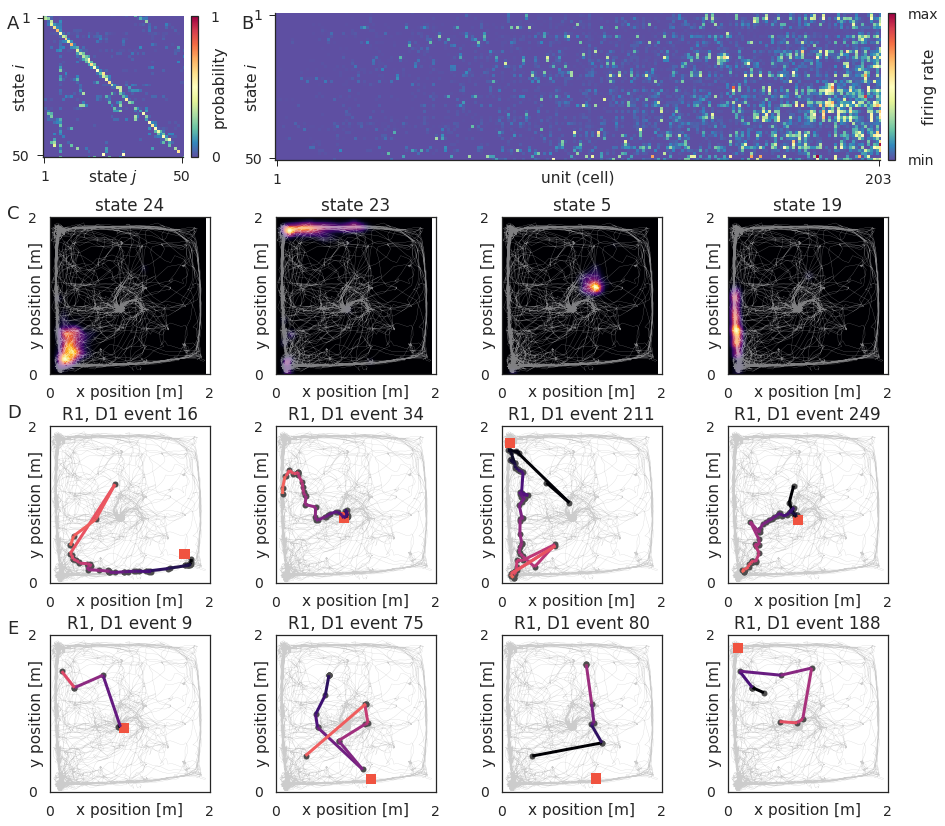

In [133]:
fig = plt.figure(1, figsize=(13, 12))

## define the figure layout
axes = figure_layout(fig)

## define figure parameters and color pallete
text_kws = dict(ha="center", size=7)
fig_kws = dict(text_kws=text_kws, rat=rat, day=day, cmap=plt.cm.Spectral_r)

## plot the various panels
plot_transmat(axes[0], **fig_kws)
plot_obsmat(axes[1], **fig_kws)

fig_kws['cmap'] = plt.cm.inferno

plot_tc(axes[2], idx=23, **fig_kws)
plot_tc(axes[3], idx=22, **fig_kws)
plot_tc(axes[4], idx=4, **fig_kws)
plot_tc(axes[5], idx=18, **fig_kws)

# plot_tc(axes[2], idx=30, **fig_kws)
# plot_tc(axes[3], idx=10, **fig_kws)
# plot_tc(axes[4], idx=13, **fig_kws)
# plot_tc(axes[5], idx=49, **fig_kws)

plot_BP_trajectory(axes[6], ex1, pathtype='path20_5', **fig_kws)
plot_BP_trajectory(axes[7], ex2, pathtype='path20_5', **fig_kws)
plot_BP_trajectory(axes[8], ex3, pathtype='path20_5', **fig_kws)
plot_BP_trajectory(axes[9], ex4, pathtype='path20_5', **fig_kws)

plot_HMM_trajectory(axes[10], hmm_ex1, pathtype='path20_1', **fig_kws)
plot_HMM_trajectory(axes[11], hmm_ex2, pathtype='path20_1', **fig_kws)
plot_HMM_trajectory(axes[12], hmm_ex3, pathtype='path20_1', **fig_kws)
plot_HMM_trajectory(axes[13], hmm_ex4, pathtype='path20_1', **fig_kws)

## annotate the figure:
# annotate_fig(fig, **fig_stuff)

## label the panels
label_panels(fig, size=18)

fig.tight_layout(pad=.5, w_pad=.75, rect=[0, .05, 1, 1])

# new clear axis overlay with 0-1 limits
# ax2 = plt.axes([0,0,1,1], axisbg=(1,1,1,0.7))
# ax2.minorticks_on()
# ax2.grid(b=True, which='major', color='k')
# ax2.grid(b=True, which='minor', color='0.4', linestyle=':')
# # ax2.grid(True)
# # gridlines = ax2.get_xgridlines() + ax2.get_ygridlines()
# # for line in gridlines:
# #     line.set_linewidth(1)
# #     line.set_color('0.5')
    
# epl.figure_grid(False)
# ax2.annotate('RUN sequencesffff', xy=(0.2, 0.6), rotation=90, color='k', va='bottom')

# epl.savefig('fff.png')
    
npl.savefig('figure6HNSBS', fig=fig, overwrite=False)